# Data Extraction

In [1]:
import urllib.request as urllib2
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import csv

In [2]:
today = datetime.date.today()
mktcap_page = 'https://coinmarketcap.com/currencies/swipe/historical-data/?start=20130428&amp;end='+"{:%Y%m%d}".format(today)
page = urllib2.urlopen(mktcap_page)
soup = BeautifulSoup(page, 'html.parser')
table = soup.find("table")

In [3]:
headings = [th.get_text().strip() for th in table.find("tr").find_all("th")]
headings

['Date', 'Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']

In [4]:
headings = [x.replace('*','') for x in headings]
headings

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']

In [5]:
datasets = []

for row in soup.find_all("tr")[1:]:
    dataset = dict(zip(headings, (tr.get_text() for tr in row.find_all("td"))))
    if len(dataset) > 1:
        datasets.append(dataset)

datasets[0]

{'Close': '2.01',
 'Date': 'Jul 24, 2020',
 'High': '2.10',
 'Low': '1.58',
 'Market Cap': '132,440,961',
 'Open': '1.63',
 'Volume': '133,396,839'}

In [6]:
my_df = pd.DataFrame(datasets)
my_df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 24, 2020",1.63,2.10,1.58,2.01,"133,396,839","132,440,961"
1,"Jul 23, 2020",1.54,1.68,1.51,1.63,"99,217,476","107,579,489"
2,"Jul 22, 2020",1.65,1.77,1.48,1.54,"61,138,949","101,303,352"
3,"Jul 21, 2020",1.66,1.75,1.38,1.65,"141,300,603","109,073,753"
4,"Jul 20, 2020",1.61,1.97,1.44,1.66,"197,782,029","109,296,706"


In [7]:
full_data = my_df.set_index('Date')
#full_data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']]
full_data.to_csv('full_data_swipe_24072020.csv', index=True, header=True)

In [8]:
full_data.head(10)

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 24, 2020",1.63,2.10,1.58,2.01,"133,396,839","132,440,961"
"Jul 23, 2020",1.54,1.68,1.51,1.63,"99,217,476","107,579,489"
"Jul 22, 2020",1.65,1.77,1.48,1.54,"61,138,949","101,303,352"
"Jul 21, 2020",1.66,1.75,1.38,1.65,"141,300,603","109,073,753"
"Jul 20, 2020",1.61,1.97,1.44,1.66,"197,782,029","109,296,706"
"Jul 19, 2020",1.19,1.67,1.13,1.61,"146,417,008","106,336,359"
"Jul 18, 2020",1.03,1.20,0.948122,1.18,"49,517,995","78,103,628"
"Jul 17, 2020",0.762262,1.05,0.759835,1.03,"54,583,403","68,241,551"
"Jul 16, 2020",0.809113,0.836219,0.717587,0.763499,"26,461,660","50,377,747"


In [9]:
full_data.shape

(334, 6)

In [10]:
full_data.dtypes

Open          object
High          object
Low           object
Close         object
Volume        object
Market Cap    object
dtype: object

In [11]:
def obj_to_int(x):
    x = x.replace(',','')
    return float(x)
full_data['Low'] = full_data['Low'].apply(obj_to_int)
full_data['High'] = full_data['High'].apply(obj_to_int)
full_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 24, 2020",1.63,2.10,1.58,2.01,"133,396,839","132,440,961"
"Jul 23, 2020",1.54,1.68,1.51,1.63,"99,217,476","107,579,489"
"Jul 22, 2020",1.65,1.77,1.48,1.54,"61,138,949","101,303,352"
"Jul 21, 2020",1.66,1.75,1.38,1.65,"141,300,603","109,073,753"
"Jul 20, 2020",1.61,1.97,1.44,1.66,"197,782,029","109,296,706"


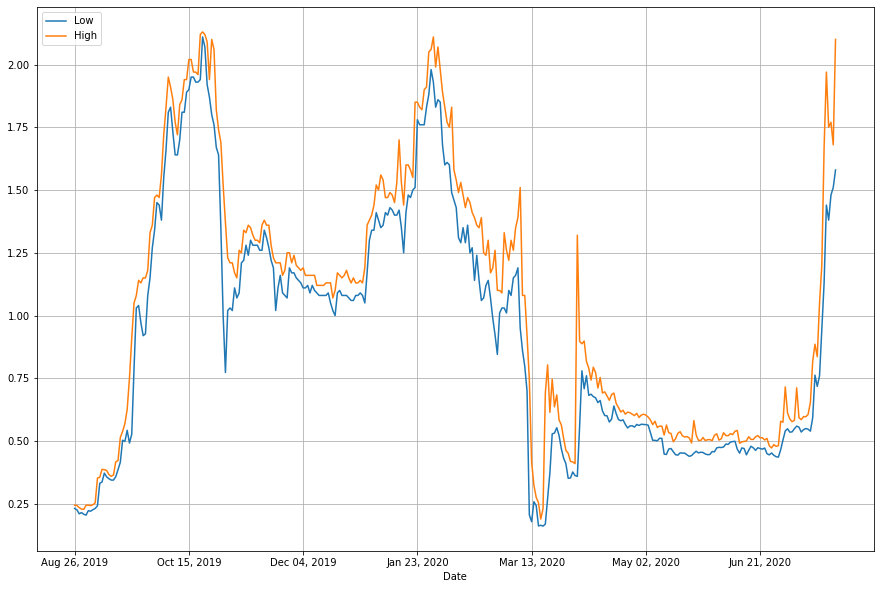

In [12]:
_= full_data[['Low','High']][::-1].plot(grid=True, figsize=(15, 10))

# Preparing data for time series

In [20]:
def obj_to_num(df,cols):
    def obj_to_num(row):
        if ',' in str(row):
          row = row.replace(',','')
          return float(row)
        else:
          return float(row)

    for col in cols: 
        df[col] = df[col].apply(obj_to_num) 
    return df
    
def prepare_data(file):
  dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y').strftime('%Y-%m-%d')
  data  = pd.read_csv(file, parse_dates=[0], date_parser=dateparse)
  columns = ['Open','High','Low','Close','Volume','Market Cap']
  num_data = obj_to_num(data,columns)
  data['Date'] = data['Date'].dt.tz_localize(None)
  data = data.groupby([pd.Grouper(key='Date', freq='H')]).first().reset_index()
  data = data.set_index('Date')
  data = data[['High']]
  data.dropna(subset=['High'], inplace=True)
  return data

In [21]:
file = 'full_data_swipe_24072020.csv'
data = prepare_data(file)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


,High
Date,
2019-08-26,0.244190
2019-08-27,0.243457
2019-08-28,0.234608
2019-08-29,0.228599
2019-08-30,0.228015


In [22]:
data.index

DatetimeIndex(['2019-08-26', '2019-08-27', '2019-08-28', '2019-08-29',
               '2019-08-30', '2019-08-31', '2019-09-01', '2019-09-02',
               '2019-09-03', '2019-09-04',
               ...
               '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-18',
               '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22',
               '2020-07-23', '2020-07-24'],
              dtype='datetime64[ns]', name='Date', length=334, freq=None)

In [23]:
!pip install chart_studio

     |████████████████████████████████| 71kB 2.0MB/s 


In [24]:
import plotly.graph_objects as go
import chart_studio as py

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [25]:
py.tools.set_credentials_file(username='xxxx', api_key='xxxxxxx')

In [27]:
trace1 = go.Scatter(
    x = data.index,
    y = data['High'].astype(float),
    mode = 'lines',
    name = 'swipe Price (High)'
)

layout = dict(
    title='Historical swipe High price (USD) (...-2020)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data = data.copy(), layout=layout)
py.plotly.iplot(fig, filename = "Time Series with Rangeslider")

# Now the model

In [30]:
!pip install pyramid-arima
from pyramid.arima import auto_arima

In [31]:
# We do this again because the fo@#!ing pyplot plot changed data types 
file = 'full_data_swipe_24072020.csv'
data = prepare_data(file)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [32]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-495.538, BIC=-476.681, Fit time=6.307 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-327.429, BIC=-319.886, Fit time=0.135 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-389.549, BIC=-374.463, Fit time=1.946 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-496.985, BIC=-481.899, Fit time=3.862 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-495.131, BIC=-476.274, Fit time=4.847 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-328.592, BIC=-317.278, Fit time=0.508 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-495.186, BIC=-476.328, Fit time=11.132 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-498.354, BIC=-475.725, Fit time=13.077 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-496.553, BIC=-470.153, Fit time=15.962 seconds
Fit ARIMA: order=(0, 1, 0

In [33]:
stepwise_model.aic()

-500.0858257285669

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2019-08-26 to 2020-07-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    334 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB


In [35]:
train = data.loc['2019-08-26':'2020-07-13']
train.tail()

,High
Date,
2020-07-09,0.584938
2020-07-10,0.597372
2020-07-11,0.596602
2020-07-12,0.605856
2020-07-13,0.654052


In [36]:
test = data.loc['2020-07-14':]
test.head()

,High
Date,
2020-07-14,0.817057
2020-07-15,0.885614
2020-07-16,0.836219
2020-07-17,1.050000
2020-07-18,1.200000


In [37]:
len(test)

11

In [38]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(1, 1, 2, 12), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

In [39]:
future_forecast = stepwise_model.predict(n_periods=14)

In [40]:
future_forecast

array([0.64716727, 0.63763122, 0.64606066, 0.64527946, 0.63285863,
       0.67670795, 0.63700103, 0.60661018, 0.59718874, 0.56116097,
       0.55345032, 0.55471943, 0.5440954 , 0.54435631])

In [41]:
test['Prediction'] = future_forecast[0:11].tolist()
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,High,Prediction
Date,,
2020-07-14,0.817057,0.647167
2020-07-15,0.885614,0.637631
2020-07-16,0.836219,0.646061
2020-07-17,1.050000,0.645279
2020-07-18,1.200000,0.632859
2020-07-19,1.670000,0.676708
2020-07-20,1.970000,0.637001
2020-07-21,1.750000,0.606610
2020-07-22,1.770000,0.597189
